In [37]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
from eval_plots import plot_training_curves

sns.set_style("whitegrid")


In [38]:

DATA_LOCATION = Path(
	r"data_numpy/density128.npy"
)



def plot_timestep(density,idx):
	plt.figure()
	plt.imshow(density[idx,:,:].T, origin='lower', cmap='viridis')
	plt.colorbar(label="n (arb. units)")
	plt.xlabel("x index")
	plt.ylabel("z index")
	plt.title("Density at timestep 50")
	plt.grid(False)
	plt.show()

data = np.load(DATA_LOCATION)


In [39]:
max_val = np.max(data)
density_data = data/max_val

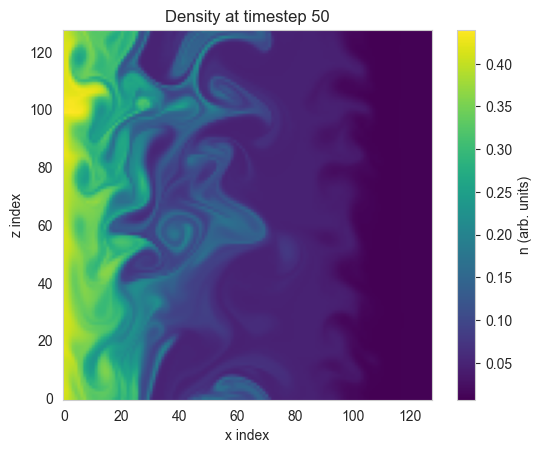

In [40]:
plot_timestep(density_data, idx=10)

# It seems to be fitting to have the edge of the man plasma at x = 200

As one can see above, convergence first happens after some timesteps. An appropriate timestep for convergence would be $t = 23$

In [41]:
from torch.utils.data import TensorDataset, DataLoader, random_split
data_tensor = torch.tensor(density_data, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(1)  # add channel dim: [N, 1, H, W]

print(data_tensor.shape) # Ensure data shape matches expectation!

# train and validation split
total_count = len(data_tensor)
train_size = int(0.8 * total_count)
test_size = total_count - train_size

# Split data_tensor (not data!) so batches have channel dimension
train_dataset, test_dataset = random_split(data_tensor, [train_size, test_size])

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([280, 1, 128, 128])


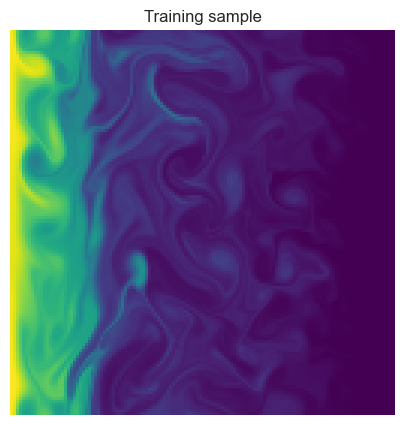

In [42]:
# Visualize a representative training sample
batch = next(iter(train_loader))
sample = batch[0]  # pick first image from batch (shape: H, W)
plt.figure(figsize=(5, 5))
plt.imshow(sample.T, origin='lower', cmap="viridis")
plt.title("Training sample")
plt.axis("off")
plt.show()

## VAE

In [43]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))




In [44]:
# Making a logistic distribution now

class Logistic(Distribution):
    arg_constraints = {}
    support = torch.distributions.constraints.real
    has_rsample = True

    def __init__(self, loc, scale, validate_args=False):
        self.loc = loc
        self.scale = scale
        super().__init__(validate_args=validate_args)

    def rsample(self, sample_shape=torch.Size()):
        eps = torch.rand(sample_shape + self.loc.shape, device=self.loc.device)
        return self.loc + self.scale * torch.log(eps / (1 - eps))

    def log_prob(self, x):
        z = (x - self.loc) / self.scale
        return -z - torch.log(self.scale) - 2 * torch.log1p(torch.exp(-z))

In [45]:
class ConvolutionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Convolutional encoder keeps the code compact while extracting spatial features.
        self.conv_encoder = nn.Sequential(
            # Block 1: 128 -> 64
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 2: 64 -> 32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 3: 32 -> 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Block 4: 16 -> 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Flatten(),
            # Flattened size: 256 channels * 8 * 8 = 16384
            nn.Linear(256 * 8 * 8, latent_features * 2) 
        )

        
        self.conv_decoder = nn.Sequential(
            nn.Linear(latent_features, 256 * 8 * 8), # Upscale linear layer
            nn.Unflatten(dim=1, unflattened_size=(256, 8, 8)), # Reshape
            
            # Block 1: 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Block 2: 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # Block 3: 32 -> 64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 4: 64 -> 128
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        # Prior parameters stay identical to the dense version.
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))

        # Define the learnable log-scale parameter
        self.log_scale = nn.Parameter(torch.tensor([0.0]))

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.conv_encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        log_sigma = torch.clamp(log_sigma,min=-10, max=10)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    # def observation_model(self, z:Tensor) -> Distribution:
    #     """return the distribution `p(x|z)`"""
    #     px_logits = self.conv_decoder(z)
    #     #px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
    #     return Bernoulli(logits=px_logits, validate_args=False)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        mu = self.conv_decoder(z)
        #scale = 0.1 # Fixed standard deviation #TODO. look at this
        scale = torch.exp(self.log_scale)
        return torch.distributions.Normal(mu, scale)
        
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}


latent_features = 2
# Example usage once you have tensors shaped as (batch, 1, H, W):

In [46]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [47]:
print(density_data[22,:,:].shape)
test = torch.tensor(data[22,:,:], dtype=torch.float32).clone()
print(test.shape)
test = test.unsqueeze(0).unsqueeze(0)
print(test.shape)

(128, 128)
torch.Size([128, 128])
torch.Size([1, 1, 128, 128])


In [48]:
# Testing if valid dimensions in Convolutional VAE
dummy_tensor = test
#dummy_tensor = torch.tensor(density_data[0,:,:,:].reshape(1,1028,1024), dtype=torch.float32)
C_VAE = ConvolutionalVariationalAutoencoder(dummy_tensor.shape, latent_features)
# Going manually through the the forward() method

# define the posterior q(z|x) / encode x into q(z|x)
qz = C_VAE.posterior(dummy_tensor)

# define the prior p(z)
pz = C_VAE.prior(batch_size=dummy_tensor.size(0))

# sample the posterior using the reparameterization trick: z ~ q(z | x)
z = qz.rsample()

# define the observation model p(x|z) = B(x | g(z))
px = C_VAE.observation_model(z)

print(px)

Normal(loc: torch.Size([1, 1, 128, 128]), scale: torch.Size([1, 1, 128, 128]))


In [49]:
images = test

vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(C_VAE, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =  16430.092, shape: []
elbo   | mean = -16430.092, shape: [1]
log_px | mean = -16429.586, shape: [1]
kl     | mean =      0.506, shape: [1]


In [50]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 32
cvae = ConvolutionalVariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.75
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

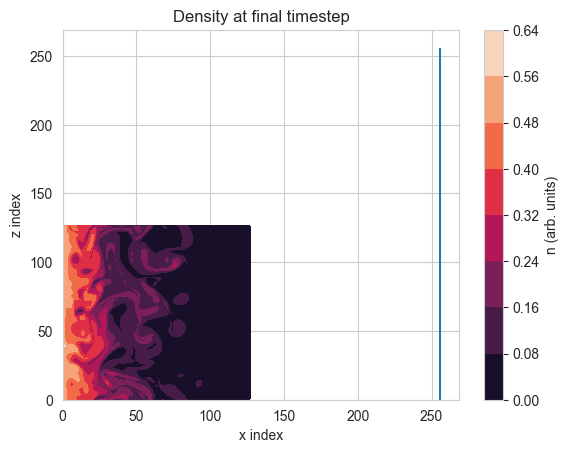

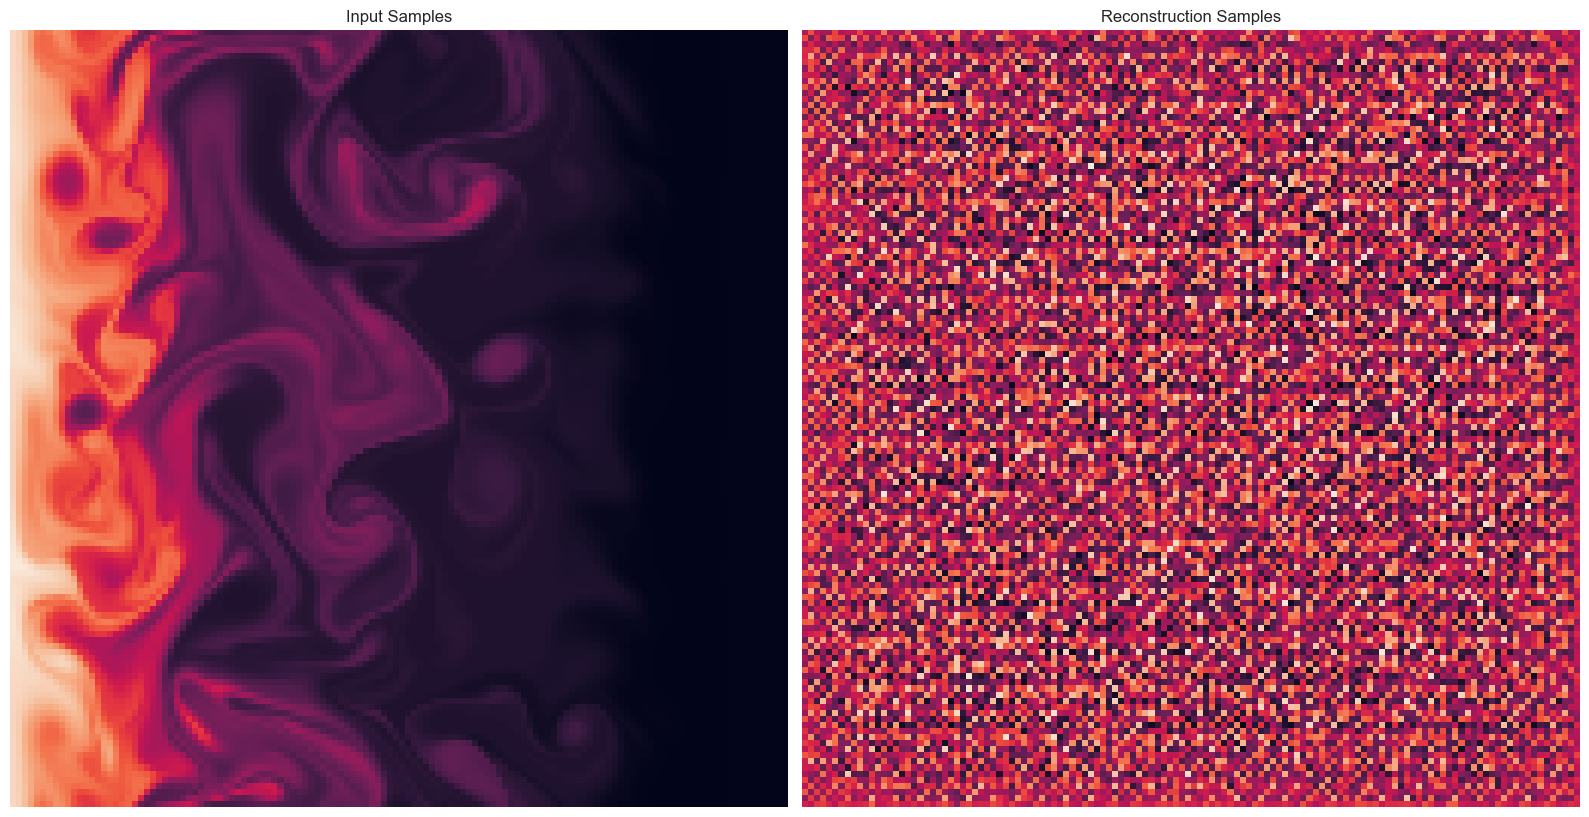

In [51]:
from plotting import make_plasma_vae_plots
from torchvision.utils import make_grid



# Try plotting the dummy data

"""Plot the density at the final time step."""
fig, ax = plt.subplots()
contour = ax.contourf(dummy_tensor[0, 0, :, :].T)
fig.colorbar(contour, ax=ax, label="n (arb. units)")
ax.set_title("Density at final timestep")
ax.set_xlabel("x index")
ax.set_ylabel("z index")
ax.vlines(256, 0, 256)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16,14))
# --------------------
# Input (left)
# --------------------
axes[0].set_title("Input Samples")
x_input = dummy_tensor  # [B, C, H, W]

# Make sure it's a NumPy array for slicing
img = x_input[0, 0].cpu().numpy().T[::-1, :]  # transpose + flip horizontally
axes[0].imshow(img, cmap='rocket')
axes[0].axis("off")

# --------------------
# Reconstruction (right)
# --------------------

axes[1].set_title("Reconstruction Samples")
# x_hat_sample = px.sample().squeeze(2)  # [B, C, H, W]
# img_hat = px.probs[0,0].cpu().detach().numpy().T[::-1, :]
img_hat = px.mean[0, 0].cpu().detach().numpy().T[::-1, :]
# img_hat = x_hat_sample[0, 0, :, :].cpu().numpy().T[::-1, :]
axes[1].imshow(img_hat, cmap='rocket')
axes[1].axis("off")


plt.tight_layout()
plt.show()

# make_plasma_vae_plots(C_VAE, px, outputs, training_data, validation_data)

### Training and Evaluation

In [52]:
from collections import defaultdict
from plotting import make_plasma_vae_plots
# define the models, evaluator and optimizer

# CVAE
latent_features = 26
cvae = ConvolutionalVariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.75 # Might change
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)



In [ ]:
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
cvae = cvae.to(device)

# training..
epoch = 0
while epoch < num_epochs:
    epoch+= 1

    # Update beta dynamically
    target_beta = 0.75
    annealing_epochs = 10
    vi.beta = min(target_beta, (epoch / annealing_epochs) * target_beta)


    training_epoch_data = defaultdict(list)
    cvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(cvae, x)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clip to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(cvae.parameters(), 1.0)

        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
      

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on the full test set, do not propagate gradients
    with torch.no_grad():
        cvae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        # Iterate through the entire test loader
        for x in test_loader:
            x = x.to(device)
            
            # perform a forward pass through the model and compute the ELBO
            loss, diagnostics, outputs = vi(cvae, x)
            
            # gather data for the validation step
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]
        
        # Average the metrics over the validation set and store
        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(v)]
    
    #print(f"{epoch} iterations completed")
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    if epoch % 10 == 0:
        #make_plasma_vae_plots(cvae, x, outputs, training_data, validation_data)
        clear_output(wait=True)
        train_vis = {k: v[2:] for k, v in training_data.items()}
        val_vis = {k: v[2:] for k, v in validation_data.items()}
        
        plot_training_curves(train_vis, val_vis)

>> Using device: cpu


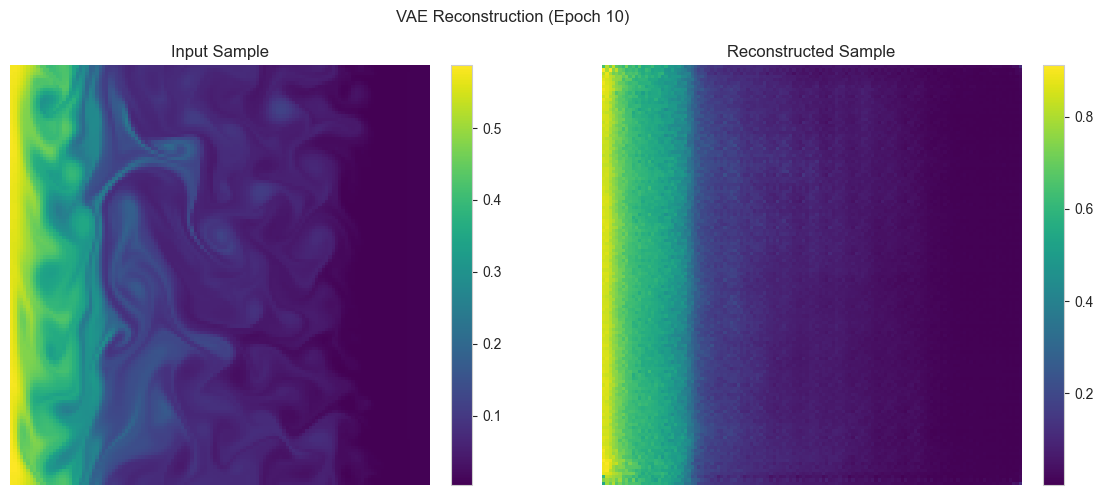

In [ ]:
# Visualize a sample from the trained model
cvae.eval()
with torch.no_grad():
    # Get a batch from the test loader
    x = next(iter(test_loader))
    x = x.to(device)

    # Forward pass
    outputs = cvae(x)
    px = outputs['px']
    
    # Get reconstruction (mean of the distribution)
    x_hat = px.mean

    # Move to cpu for plotting
    # Select the first image in the batch
    x_sample = x[0, 0].cpu().numpy()
    x_hat_sample = x_hat[0, 0].cpu().numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Input
    im1 = axes[0].imshow(x_sample.T, origin='lower', cmap='viridis')
    axes[0].set_title("Input Sample")
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Reconstruction
    im2 = axes[1].imshow(x_hat_sample.T, origin='lower', cmap='viridis')
    axes[1].set_title("Reconstructed Sample")
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.suptitle(f"VAE Reconstruction (Epoch {epoch})")
    plt.tight_layout()
    plt.show()